In [1]:
using MarkovNets,Factors

# Usage for Markov Fields

## Basic Usage

A Markov Field is represented as an MRF type containting an undirected graph modeling the conditional independence of the joint probability distribution. Each node is associated to a name, and an MRF contains a list of `Factor`s, who represent the probability distribution. The joint probability distribution is the product of all the `Factor`s. 

So far this only supports discrete distributions. Priority to extend this to Gaussian models.

To build an MRF, the recommended way is simply to construct factors, then to call the MRF constructor with a list of factors. The constructor will then build the representation of the MRF (i.e. an edge will be added between all nodes that are featured in common factors).

In [2]:
f = Factor([:a, :b], [1 1; 1 1])
g = Factor([:b, :c], [1 1;1 2])
factors = [f, g]
mn = MarkovNet(factors)

## Sampling
Sampling in MRFs is done through *Gibbs Sampling*. We will use as a basic example an Ising model. 

For this we need to build a 'grid' graph. We then use the graph to create the list of associated factors. Each node is has two possible values, `1` or `2`. The factors are pairwise and reflect that two neighboring nodes have a tendency to align.

### Ising Model

In [3]:
using LightGraphs # we need this to build our factor list.
using Plots
gr(size = (300,300), scale = 1)

Plots.GRBackend()

Building the Grid:

In [4]:
n = 32
grid = Grid([n,n])

{1024, 1984} undirected graph

In [5]:
interact = .7 # this is our interaction energy

# we then define the factor matrix:
interact_array = [exp(interact) exp(-interact);
                  exp(-interact) exp(interact)]

factors = Array{Factor}(length(edges(grid)))

# and create pairwise factors for neighboring nodes on the grids
for (i,e) in enumerate(edges(grid))
    factors[i] = Factor([Symbol(e[1]), Symbol(e[2])], interact_array)
end

mn = MarkovNet(factors);


In [6]:
# creating the sampler object - right now the Givvs sampler is the only one available
sampler = MNGibbsSampler(Assignment(), burn_in = 0)

MarkovNets.MNGibbsSampler(Dict{Symbol,Any}(),0,0,Nullable{Dict{Symbol,Any}}())

In [7]:
# the running the sampler - this can take a while
iters = 10
@time df = rand(mn, sampler, iters);

  8.982412 seconds (12.50 M allocations: 1.809 GB, 4.28% gc time)


In [8]:
    # some code to look at our Ising Model
orderednames = [Symbol(i) for i in 1:length(vertices(grid))]
a = reshape(convert(Array{Float64},df[1,orderednames]), (n, n) )
plt = heatmap(a, axis = nothing)

@gif for i=1:iters
    a = reshape(convert(Array{Float64}, df[i,orderednames]), (n, n))
    heatmap!(a, axis = nothing)
end

INFO: Saved animation to /Users/henripal/.julia/v0.5/MarkovNets/doc/tmp.gif


Plots.AnimatedGif("/Users/henripal/.julia/v0.5/MarkovNets/doc/tmp.gif")

### Potts Model
Since this framework is flexible in terms of the interactions, it is easy to build more complicated models using the same procedure. For example we can build a 4 color Potts model on a grid in the same manner:

In [9]:
interact = .7 # this is our interaction energy

# This is the only difference from our previous example ###
interact_array = [exp(interact) exp(-interact) exp(-interact) exp(-interact);
                  exp(-interact) exp(interact) exp(-interact) exp(-interact);
                  exp(-interact) exp(-interact) exp(interact) exp(-interact);
                  exp(-interact) exp(-interact) exp(-interact) exp(interact)]
    
factors = Array{Factor}(length(edges(grid)))

# and create pairwise factors for neighboring nodes on the grids
for (i,e) in enumerate(edges(grid))
    factors[i] = Factor([Symbol(e[1]), Symbol(e[2])], interact_array)
end

mn = MarkovNet(factors);

In [10]:
# the running the sampler - this can take a while
iters = 20
@time df = rand(mn, sampler, iters);

 11.127690 seconds (19.18 M allocations: 3.381 GB, 7.95% gc time)


In [11]:
# some code to look at our Potts Model
orderednames = [Symbol(i) for i in 1:length(vertices(grid))]
a = reshape(convert(Array{Float64},df[1,orderednames]), (n, n) )
plt = heatmap(a, axis = nothing)

potts_anim = @animate for i=1:iters
    a = reshape(convert(Array{Float64}, df[i,orderednames]), (n, n))
    heatmap!(a, axis = nothing)
end

gif(potts_anim, "potts_anim.gif", fps = 20)

INFO: Saved animation to /Users/henripal/.julia/v0.5/MarkovNets/doc/potts_anim.gif


Plots.AnimatedGif("/Users/henripal/.julia/v0.5/MarkovNets/doc/potts_anim.gif")

## Inference
Here we use the MRF to denoise a black and white image - the idea is that the MRF is still a grid, and that the interactions between neighbors still encourages local coherence, but now we connect an extra node to each node on the grid, corresponding to the value of the pixel. The ground state will then correspond to an image with 
* local coherence
* close to the target image

In [12]:
using Images, TestImages, Distributions, LightGraphs 

Let's load a sample image, convert it to grayscale, and add some noise by 'turning off' some pixels.

data(A) is deprecated for arrays that are not an ImageMeta. To avoid
using `data`, structure your code like this:

    function myfunction(img::AbstractArray, args...)
        # "real" algorithm goes here
    end
    myfunction(img::ImageMeta, args...) = myfunction(data(img), args...)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in data(::Array{ColorTypes.Gray{Float32},2}) at /Users/henripal/.julia/v0.5/ImageCore/src/deprecated.jl:88
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/henripal/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /Users/henripal/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[13], in expression starting on line 4
 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in grayim(::Array{Float64,2}) at /Users/henripal/.julia/v0.5/ImageCore/src/deprecated.jl:6
 in include_string(::String, ::String) at ./loading

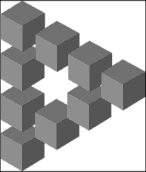

In [13]:
n_levels = 9
img = restrict(restrict(Images.load("geom.png")))
im_x_size, im_y_size = size(img)
img_data = convert(Array{Int}, round.(n_levels.*Images.data(Images.Gray.(img))))
grayim(img_data/n_levels)

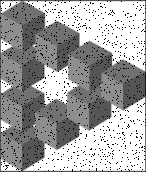

In [14]:
noisy_img_data = img_data  .*rand(Bernoulli(.94),im_x_size,im_y_size)
grayim(noisy_img_data/n_levels)

We now create a pairwise connected grid using Lightgraph

In [15]:
new_grid = Grid([im_x_size,im_y_size])
im_size = im_x_size * im_y_size

25112

We now create the factor functions. The idea is to have higher energies for more distant shades of gray. We choose to use the square of the difference between the shades.
We also use a factor `data mult` to specify the network's preference to being like the data rather than like the neighbors.

In [16]:
data_mult = 1.4
interact_array = convert(Array{Float64,2},[1/(1+(i-j)^2) for i in 1:(n_levels +1), j in 1:(n_levels+1)])
interact_data = data_mult * interact_array 

10×10 Array{Float64,2}:
 1.4        0.7        0.28       …  0.028      0.0215385  0.0170732
 0.7        1.4        0.7           0.0378378  0.028      0.0215385
 0.28       0.7        1.4           0.0538462  0.0378378  0.028    
 0.14       0.28       0.7           0.0823529  0.0538462  0.0378378
 0.0823529  0.14       0.28          0.14       0.0823529  0.0538462
 0.0538462  0.0823529  0.14       …  0.28       0.14       0.0823529
 0.0378378  0.0538462  0.0823529     0.7        0.28       0.14     
 0.028      0.0378378  0.0538462     1.4        0.7        0.28     
 0.0215385  0.028      0.0378378     0.7        1.4        0.7      
 0.0170732  0.0215385  0.028         0.28       0.7        1.4      

We then need to add the 'data' layer to the grid, adding one vertex per pre-existing vertex, linked not to its neighbors but to its corresponding hidden node

In [17]:
add_vertices!(new_grid, im_size)
for i in 1:(im_size)
    add_edge!(new_grid, i, i+im_size)
end

We then fill out the hidden neighbor interaction energies and the hidden node/data node interaction energies.

In [18]:
factors = Array{Factor}(length(edges(new_grid)))

# and create pairwise factors for neighboring nodes on the grids
for (i,e) in enumerate(edges(new_grid))
    if (e[1]>=im_size) || (e[2]>=im_size)
        factors[i] = Factor([Symbol(e[1]), Symbol(e[2])], interact_data)
    else
        factors[i] = Factor([Symbol(e[1]), Symbol(e[2])], interact_array)
    end
end

mn = MarkovNet(factors);

Finally, we assign the pixel values to the data nodes and create our sampler object

In [25]:
# creating the sampler object - right now the Gibbs sampler is the only one available
img_nodes = [Symbol(i) for i in (im_size+1):(2*im_size)]
img_values = noisy_img_data[:]+1
assgn = Assignment(zip(img_nodes, img_values))
sampler = MNGibbsSampler(assgn, burn_in = 0);

We run the Gibbs sampler to process the denoising.

In [ ]:
iters = 20
@time df = rand(mn, sampler, iters);

In [ ]:
# some code to look at our Potts Model
orderednames = [Symbol(i) for i in 1:(im_size)]
a = reshape(convert(Array{Float64},df[1,orderednames]), (im_x_size, im_y_size) )
rebuiltim = grayim((a-1)/n_levels)

In [ ]:
# re-run this cell to see the convergence animation: for i in 1:iters
    a = reshape(convert(Array{Float64},df[i,orderednames]), (im_x_size, im_y_size) )
    display(grayim((a-1)/n_levels))
    IJulia.clear_output(true)
end